# Settings

In [2]:
Grouping = 'Monat' # Alternativ Quartal
Sport = 'Running'
MIN_LAP_TRIM = 2
MAX_LAP_TRIM = 2
FILTER_OUT_PERCENTAGE_BEGINNING = 0.2
FILTER_OUT_PERCENTAGE_END = 0.8

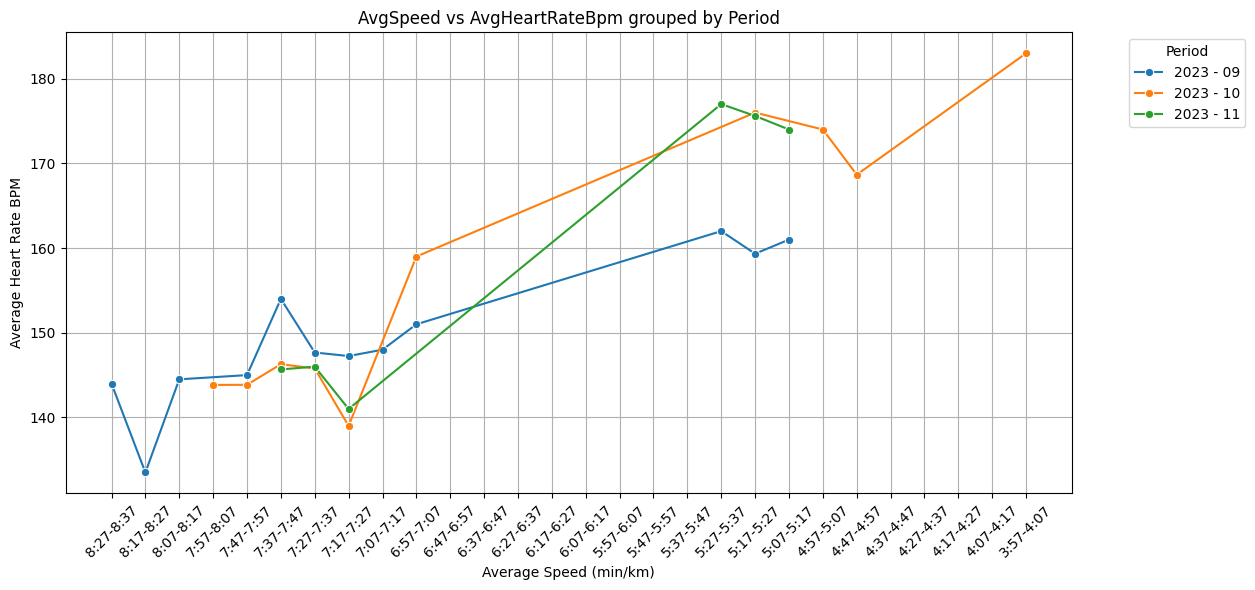

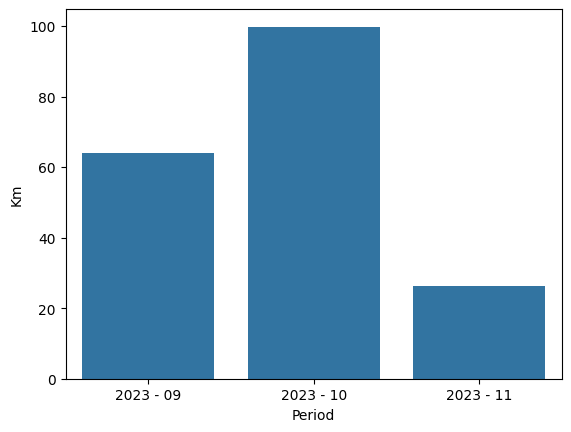

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree
import seaborn as sns
import io
import numpy as np
from datetime import datetime

def convert_to_min_sec(x):
    minutes = int(x)
    seconds = int((x - minutes) * 60)
    return f"{minutes}:{seconds:02d}"

def map_date_to_quarter(date_str):
    # Parse the date string
    date = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ") 
    # Determine the quarter
    if 1 <= date.month <= 3:
        quarter = "Q1"
    elif 4 <= date.month <= 6:
        quarter = "Q2"
    elif 7 <= date.month <= 9:
        quarter = "Q3"
    else:
        quarter = "Q4"
    # Return the formatted string
    return f"{date.year} - {quarter}"

def remove_first_n_and_last_m(arr, n_first, m_last):
    if len(arr) >= n_first + m_last:
        arr = arr[n_first:-m_last]
        return arr
    else:
        return []


namespaces = {
    'default': "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2",
    'ns3': "http://www.garmin.com/xmlschemas/ActivityExtension/v2",
    # Add other namespaces here as needed
}

with open('merged.tcx', 'rb') as file:
    xml_data = file.read()
    root = etree.fromstring(xml_data)
    
data_laps = []
data_activities = []
for activity in root.findall(".//default:Activity", namespaces=namespaces):
    if activity.get('Sport') == Sport:
        laps = activity.findall(".//default:Lap", namespaces=namespaces)
        laps = remove_first_n_and_last_m(laps, MIN_LAP_TRIM, MAX_LAP_TRIM)
        for lap in laps:
            distance = float(lap.find("default:DistanceMeters", namespaces=namespaces).text)
            if distance >= 500:
                avg_heart_rate = int(lap.find(".//default:AverageHeartRateBpm/default:Value", namespaces=namespaces).text)
                max_heart_rate = int(lap.find(".//default:MaximumHeartRateBpm/default:Value", namespaces=namespaces).text)
                if abs(avg_heart_rate-max_heart_rate)<=8:
                    time = lap.get("StartTime")
                    if Grouping == 'Monat':
                        period = time.split("-")[0] + ' - ' + time.split("-")[1]  # Extracting month and year
                    elif Grouping == 'Quartal':
                        period = map_date_to_quarter(time)
                    avg_speed = lap.find(".//ns3:AvgSpeed", namespaces=namespaces).text
                    data_laps.append((period, float(avg_speed), int(avg_heart_rate)))

for activity in root.findall(".//default:Activity", namespaces=namespaces):
    if activity.get('Sport') == Sport:
        activity_id = activity.find("default:Id", namespaces=namespaces).text
        if Grouping == 'Monat':
            activity_period = activity_id.split("-")[0] + ' - ' + activity_id.split("-")[1]  # Extracting month and year
        elif Grouping == 'Quartal':
            activity_period = map_date_to_quarter(activity_id)
        acc_distance = 0
        laps = activity.findall(".//default:Lap", namespaces=namespaces)
        for lap in laps:
            distance = float(lap.find("default:DistanceMeters", namespaces=namespaces).text)
            acc_distance += distance
        data_activities.append((activity_period, acc_distance))

# Convert data to DataFrame
df_laps = pd.DataFrame(data_laps, columns=["Period", "AvgSpeed", "AvgHeartRateBpm"])
df_laps['AvgSpeed'] = (1/df_laps['AvgSpeed']) * (1000/60)
bin_width = 10/60  # 5 seconds expressed in minutes
bin_edges = list(np.arange(df_laps['AvgSpeed'].min(), df_laps['AvgSpeed'].max() + bin_width, bin_width))

df_activities = pd.DataFrame(data_activities, columns=["Period", "DistanceMeters"])
df_activities['DistanceMeters'] = (df_activities['DistanceMeters']) / 1000

# Define bin labels: "0-0:05", "0:05-0:10", ... for indicating speed ranges
bin_labels = [f"{int(i)}:{int((i*60)%60):02d}-{int(i+bin_width)}:{int(((i+bin_width)*60)%60):02d}" for i in bin_edges[:-1]]

# Create a new column 'SpeedGroup' to categorize avg speed into bins
df_laps['SpeedGroup'] = pd.cut(df_laps['AvgSpeed'], bins=bin_edges, labels=bin_labels, right=False)

# Group by the new 'SpeedGroup' and Month, and calculate the mean of the heart rate for each group
grouped_laps_df = df_laps.groupby(['SpeedGroup', 'Period']).agg(AvgHeartRateBpm=('AvgHeartRateBpm', 'mean')).reset_index()
grouped_activities_df = df_activities.groupby(['Period']).agg(DistanceMeters=('DistanceMeters', 'sum')).reset_index()

# Plotting
plt.figure(figsize=(30,6))
sns.lineplot(data=grouped_laps_df, x='SpeedGroup', y='AvgHeartRateBpm', hue='Period', marker="o")

plt.title('AvgSpeed vs AvgHeartRateBpm grouped by Period')
plt.xlabel('Average Speed (min/km)')
plt.ylabel('Average Heart Rate BPM')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optional: Invert x-axis if you prefer lower speeds on the right
plt.gca().invert_xaxis()
plt.gca().set_aspect(1/4) 
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

sns.barplot(data=grouped_activities_df, x='Period', y='DistanceMeters')
plt.ylabel('Km')
plt.show()


# Data Reading

In [4]:
namespaces = {
    'default': "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2",
    'ns3': "http://www.garmin.com/xmlschemas/ActivityExtension/v2",
    'ns2': "http://www.garmin.com/xmlschemas/ActivityExtension/v2",
    # Add other namespaces here as needed
}

def remove_max_distance(group):
    max_distance = group['Distance'].max()
    return group[group['Distance'] > max_distance*0.1]

with open('merged.tcx', 'rb') as file:
    xml_data = file.read()
    root = etree.fromstring(xml_data)

trackpointsArr = []

for activity in root.findall(".//default:Activity", namespaces=namespaces):
    if activity.get('Sport') == Sport:
        activity_id = activity.find("default:Id", namespaces=namespaces).text
        laps = activity.findall(".//default:Lap", namespaces=namespaces)
        for lap in laps:
            track = lap.find("default:Track", namespaces=namespaces)
            trackpoints = track.findall(".//default:Trackpoint", namespaces=namespaces)
            for trackpoint in trackpoints:
                try:
                    hrt = trackpoint.find("default:HeartRateBpm", namespaces=namespaces)
                except:
                    print("Error finding default:HeartRateBpm in merged.tcx")
                try:
                    hrtValue = hrt.find("default:Value", namespaces=namespaces).text
                except:
                    print("Error finding default:Value in merged.tcx")
                try:
                    speed = trackpoint.find(".//ns2:Speed", namespaces=namespaces).text
                except:
                    print("Error finding .//ns2:Speed in merged.tcx")
                try:
                    distance = float(trackpoint.find("default:DistanceMeters", namespaces=namespaces).text)
                except:
                    print("Error finding default:DistanceMeters in merged.tcx")
                try:
                    trackpointsArr.append((activity_id, int(hrtValue), float(speed)*3.6, distance / 1000))
                except:
                    print("Error append from merged.tcx")

all_data = pd.DataFrame(trackpointsArr, columns=["ActivityId", "HeartRate", "Speed", "Distance"])
data_without_plateau = pd.DataFrame(columns=["ActivityId", "HeartRate", "Speed", "Distance"])
all_data = all_data[all_data["Speed"] > 7]
all_data = all_data.reset_index()

## moving average
window_size = 3

all_data["HeartRateR"] = None
unique_identifiers = all_data['ActivityId'].unique()
for identifier in unique_identifiers:
    mask = all_data['ActivityId'] == identifier
    all_data.loc[mask, 'HeartRateR'] = all_data.loc[mask, 'HeartRate'].rolling(window=window_size, min_periods=1).median()
    all_data.loc[mask, 'SpeedR'] = all_data.loc[mask, 'Speed'].rolling(window=window_size, min_periods=1).median()

max_distances = all_data.groupby("ActivityId")["Distance"].max()
all_data = all_data.merge(max_distances, on='ActivityId', suffixes=('', '_max'))
all_data['lower_bound'] = all_data['Distance_max'] * FILTER_OUT_PERCENTAGE_BEGINNING
all_data['upper_bound'] = all_data['Distance_max'] * FILTER_OUT_PERCENTAGE_END
all_data = all_data[(all_data['Distance'] >= all_data['lower_bound']) & (all_data['Distance'] <= all_data['upper_bound'])]
all_data = all_data.drop(columns=['Distance_max', 'lower_bound', 'upper_bound'])

grouped_by_activity = all_data.groupby("ActivityId")

## find plateaus in Speed
plateausSpeed = []
tolerance = 0.5
plateau_length = 10
plateau_variable = "SpeedR"

for group_name, group_data in grouped_by_activity:
    i = 0
    while i < len(group_data)-1:
        local_plateau = []
        plateau_min = min(group_data.iloc[i][plateau_variable], group_data.iloc[i+1][plateau_variable])
        plateau_max = max(group_data.iloc[i][plateau_variable], group_data.iloc[i+1][plateau_variable])
        diff = abs(plateau_min - plateau_max)
        if diff <= tolerance:
            still_plateau = True
            local_plateau.append(group_data.iloc[i])
            local_plateau.append(group_data.iloc[i+1])
            j=i+1
            while still_plateau:
                if j+1 >= len(group_data): break
                plateau_min = min(plateau_min, group_data.iloc[j+1][plateau_variable])
                plateau_max = max(plateau_max, group_data.iloc[j+1][plateau_variable])
                diff = abs(plateau_min - plateau_max)
                if diff <= tolerance:
                    local_plateau.append(group_data.iloc[j+1])
                    j+=1
                else:
                    still_plateau = False
                    i = j
                    if len(local_plateau) > 10:
                        plateausSpeed.extend(local_plateau)
            i = j+1
        else: i+=1

df_plateausSpeed = pd.DataFrame(plateausSpeed, columns=["ActivityId", "HeartRate", "Speed", "Distance", "HeartRateR", "SpeedR"])


## find plateaus in hr after speed selection
grouped_by_activity = df_plateausSpeed.groupby("ActivityId")

plateausHR = []
plateausStatistics = []
tolerance = 5
plateau_length = 10
plateau_variable = "HeartRateR"

for group_name, group_data in grouped_by_activity:
    i = 0
    while i < len(group_data)-1:
        local_plateau = []
        plateau_min = min(group_data.iloc[i][plateau_variable], group_data.iloc[i+1][plateau_variable])
        plateau_max = max(group_data.iloc[i][plateau_variable], group_data.iloc[i+1][plateau_variable])
        diff = abs(plateau_min - plateau_max)
        if diff <= tolerance:
            still_plateau = True
            local_plateau.append(group_data.iloc[i])
            local_plateau.append(group_data.iloc[i+1])
            j=i+1
            while still_plateau:
                if j+1 >= len(group_data): break
                plateau_min = min(plateau_min, group_data.iloc[j+1][plateau_variable])
                plateau_max = max(plateau_max, group_data.iloc[j+1][plateau_variable])
                diff = abs(plateau_min - plateau_max)
                if diff <= tolerance:
                    local_plateau.append(group_data.iloc[j+1])
                    j+=1
                else:
                    still_plateau = False
                    i = j
                    if len(local_plateau) > 10:
                        plateausHR.extend(local_plateau)

                        activity_id = local_plateau[0]["ActivityId"]
                        speedr_values = [point["SpeedR"] for point in local_plateau]
                        distance_values = [point["Distance"] for point in local_plateau]
                        max_heartrater = max([point["HeartRateR"] for point in local_plateau])
                        mean_speedr = sum(speedr_values) / len(speedr_values)
                        mean_distance = sum(distance_values) / len(distance_values)
                        plateausStatistics.append({                            
                            "ActivityId": activity_id,
                            "MaxHeartRateR": max_heartrater,
                            "MeanSpeedR": mean_speedr,
                            "MeanDistance": mean_distance
                        })
            
            i = j+1
        else: i+=1

df_plateaus = pd.DataFrame(plateausHR, columns=["ActivityId", "HeartRate", "Speed", "Distance", "HeartRateR", "SpeedR"])
df_plateausStatistics = pd.DataFrame(plateausStatistics)

df_plateausStatistics['ActivityDate'] = pd.to_datetime(df_plateausStatistics['ActivityId'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df_plateausStatistics['Year'] = df_plateausStatistics['ActivityDate'].dt.year
df_plateausStatistics['Month'] = df_plateausStatistics['ActivityDate'].dt.month

# Convert MeanSpeedR from km/h to min/km
df_plateausStatistics['MeanSpeedR_min_per_km'] = 60 / df_plateausStatistics['MeanSpeedR']

Error finding default:Value in merged.tcx
Error finding default:Value in merged.tcx


# Plots

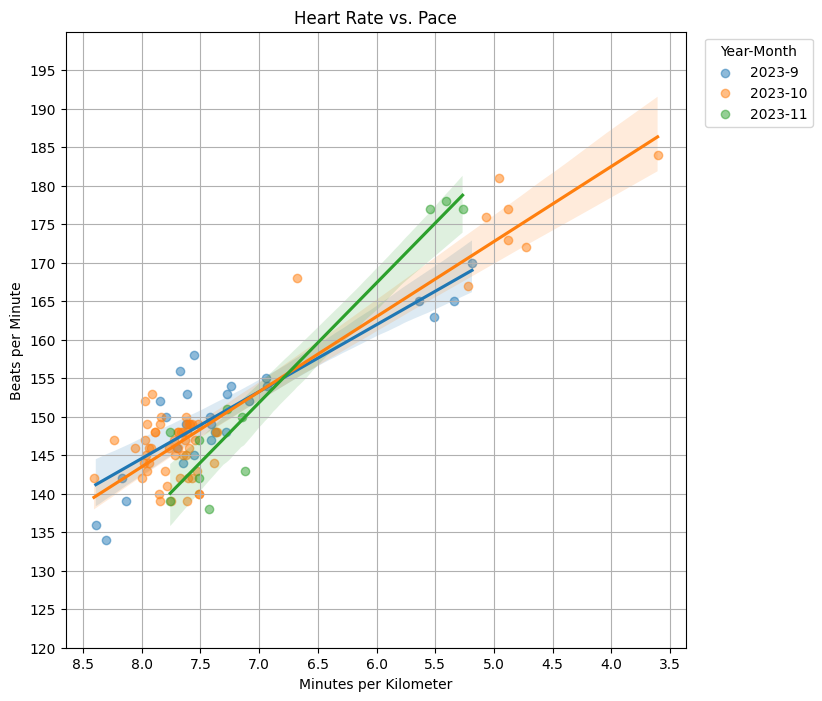

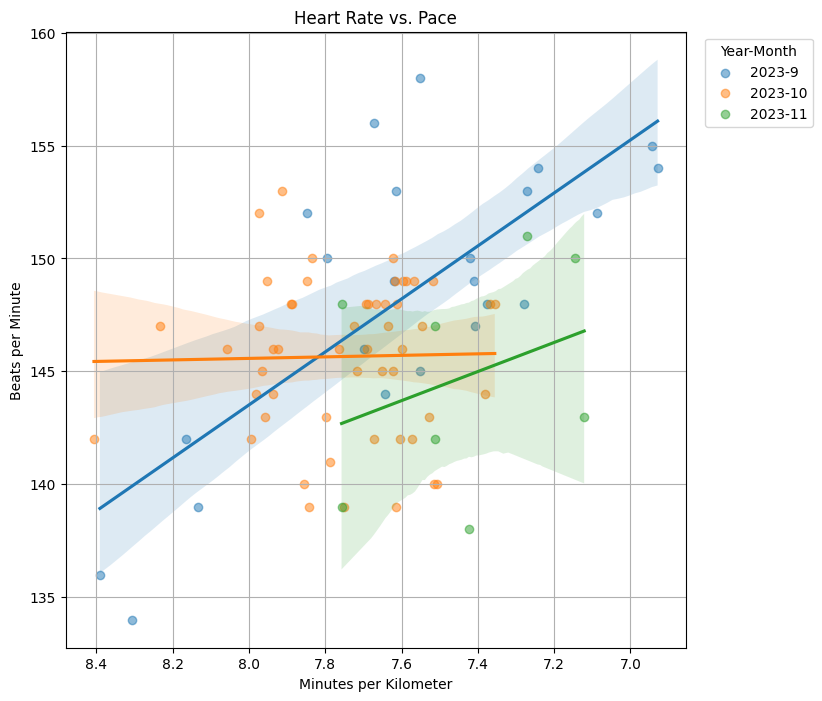

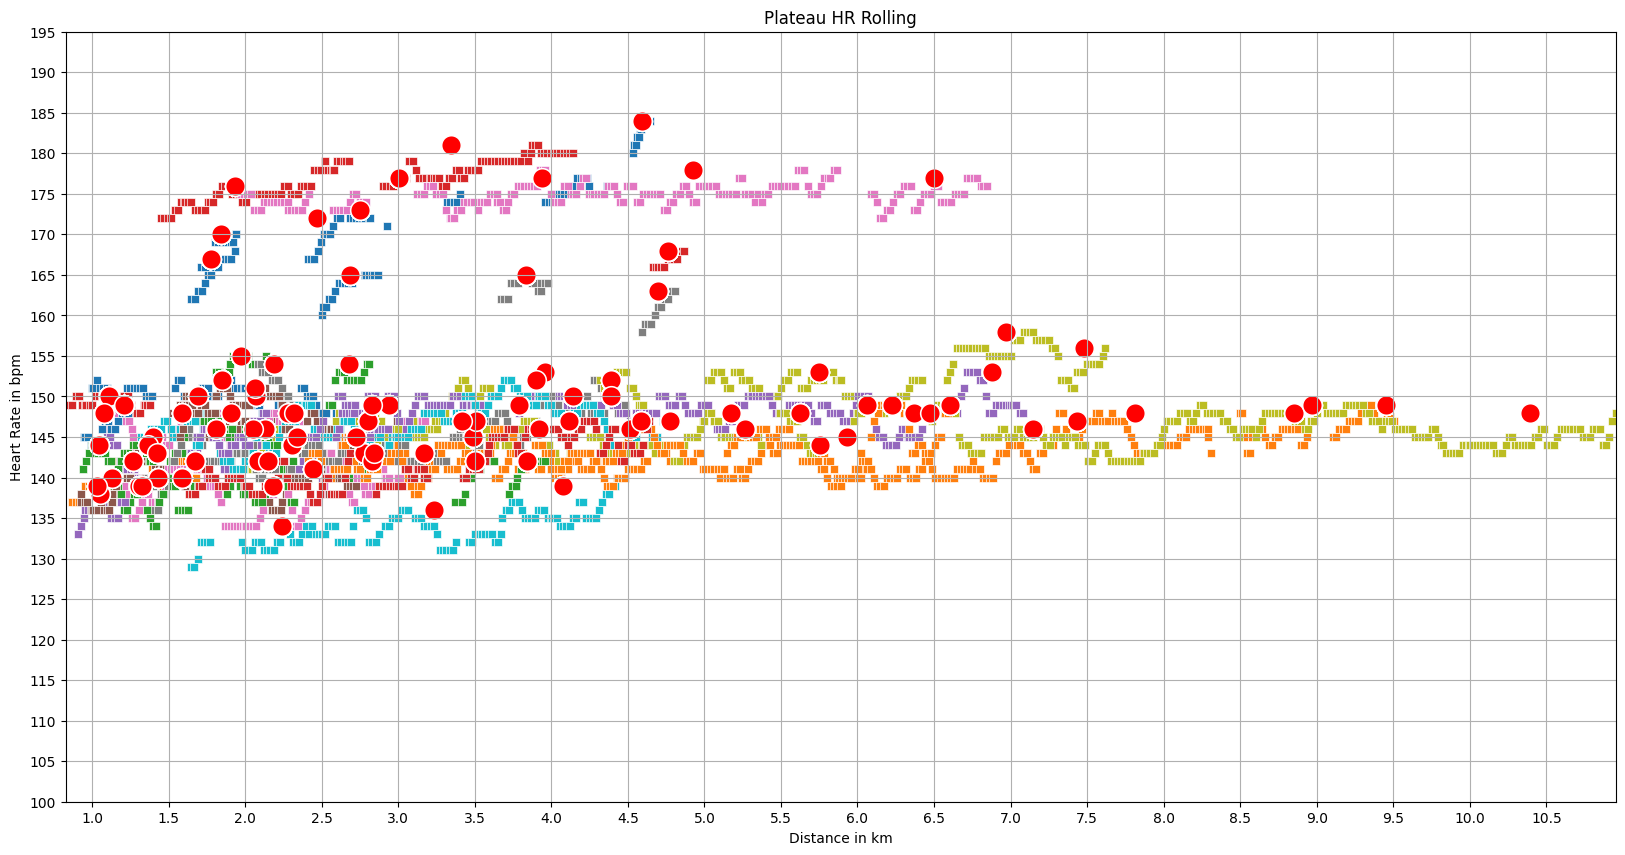

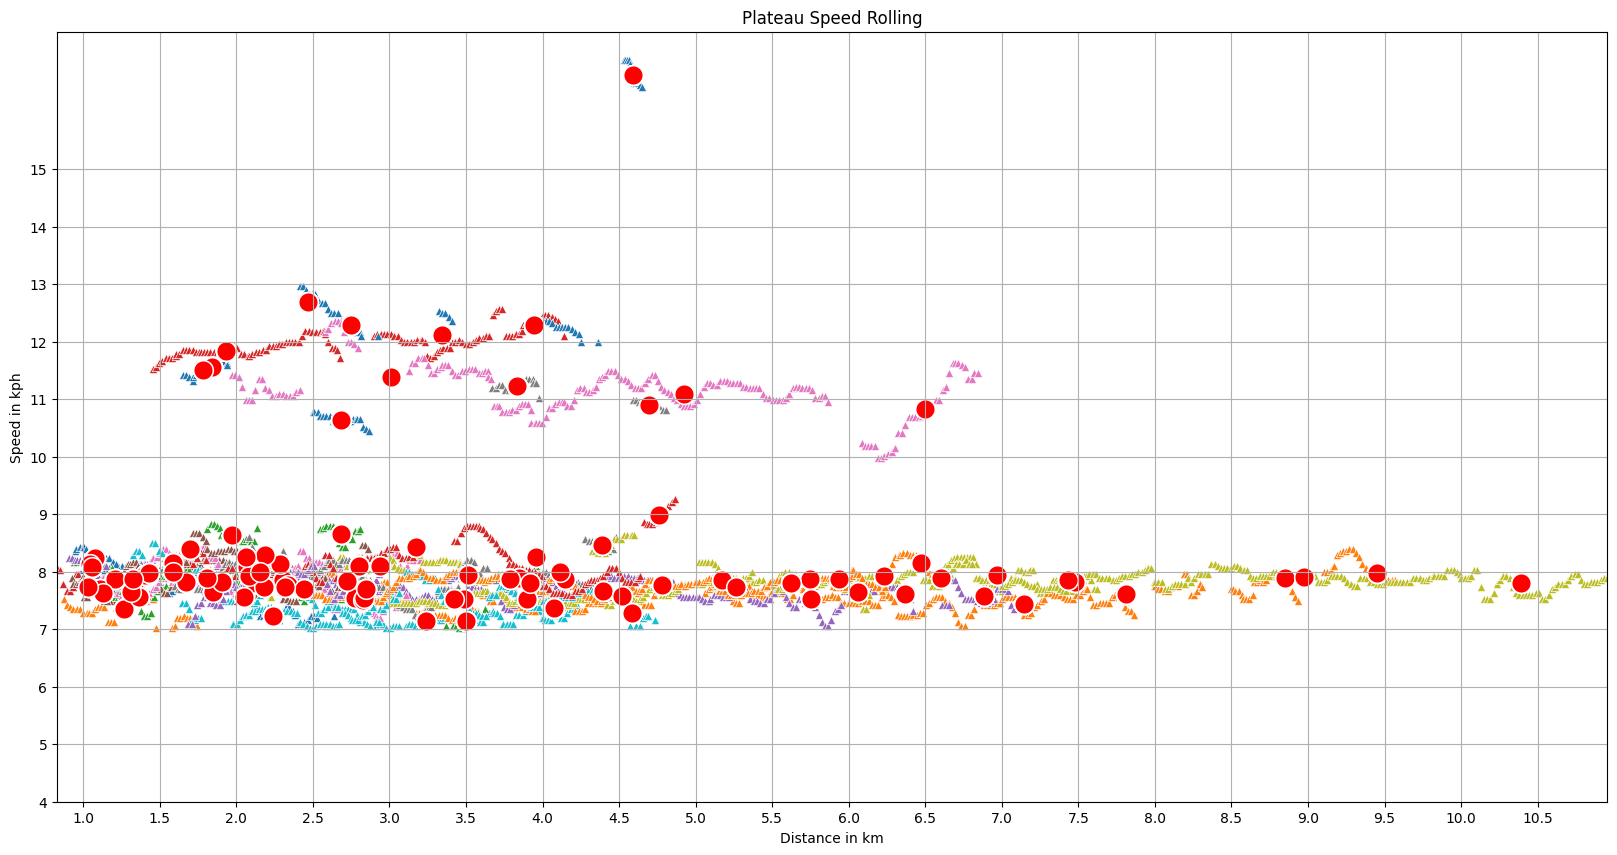

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


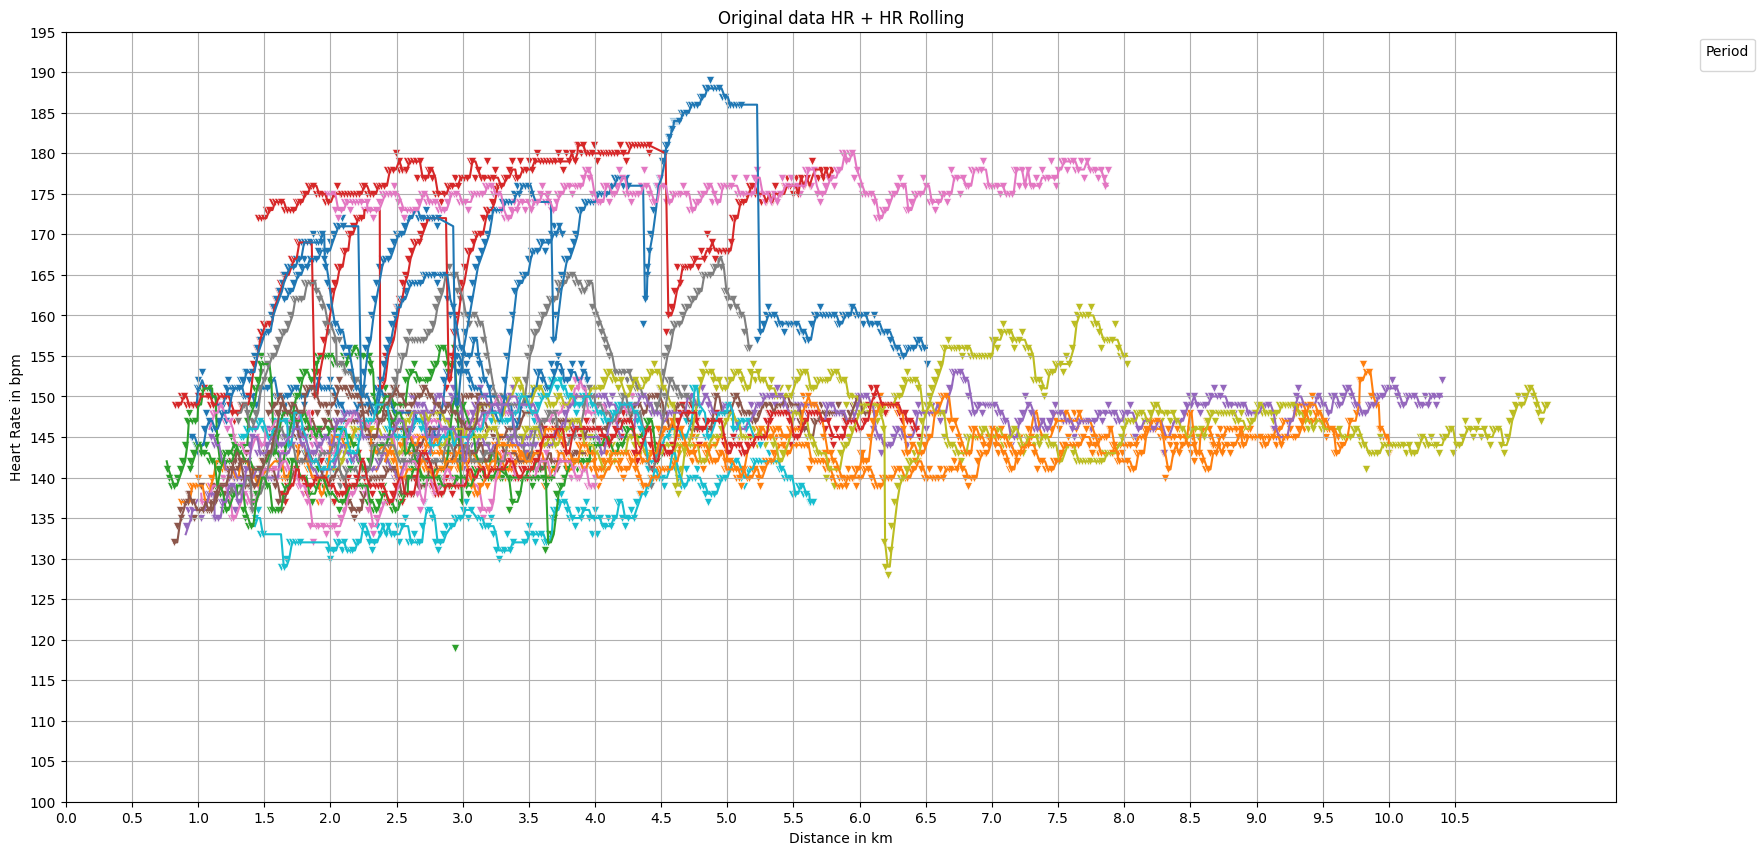

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


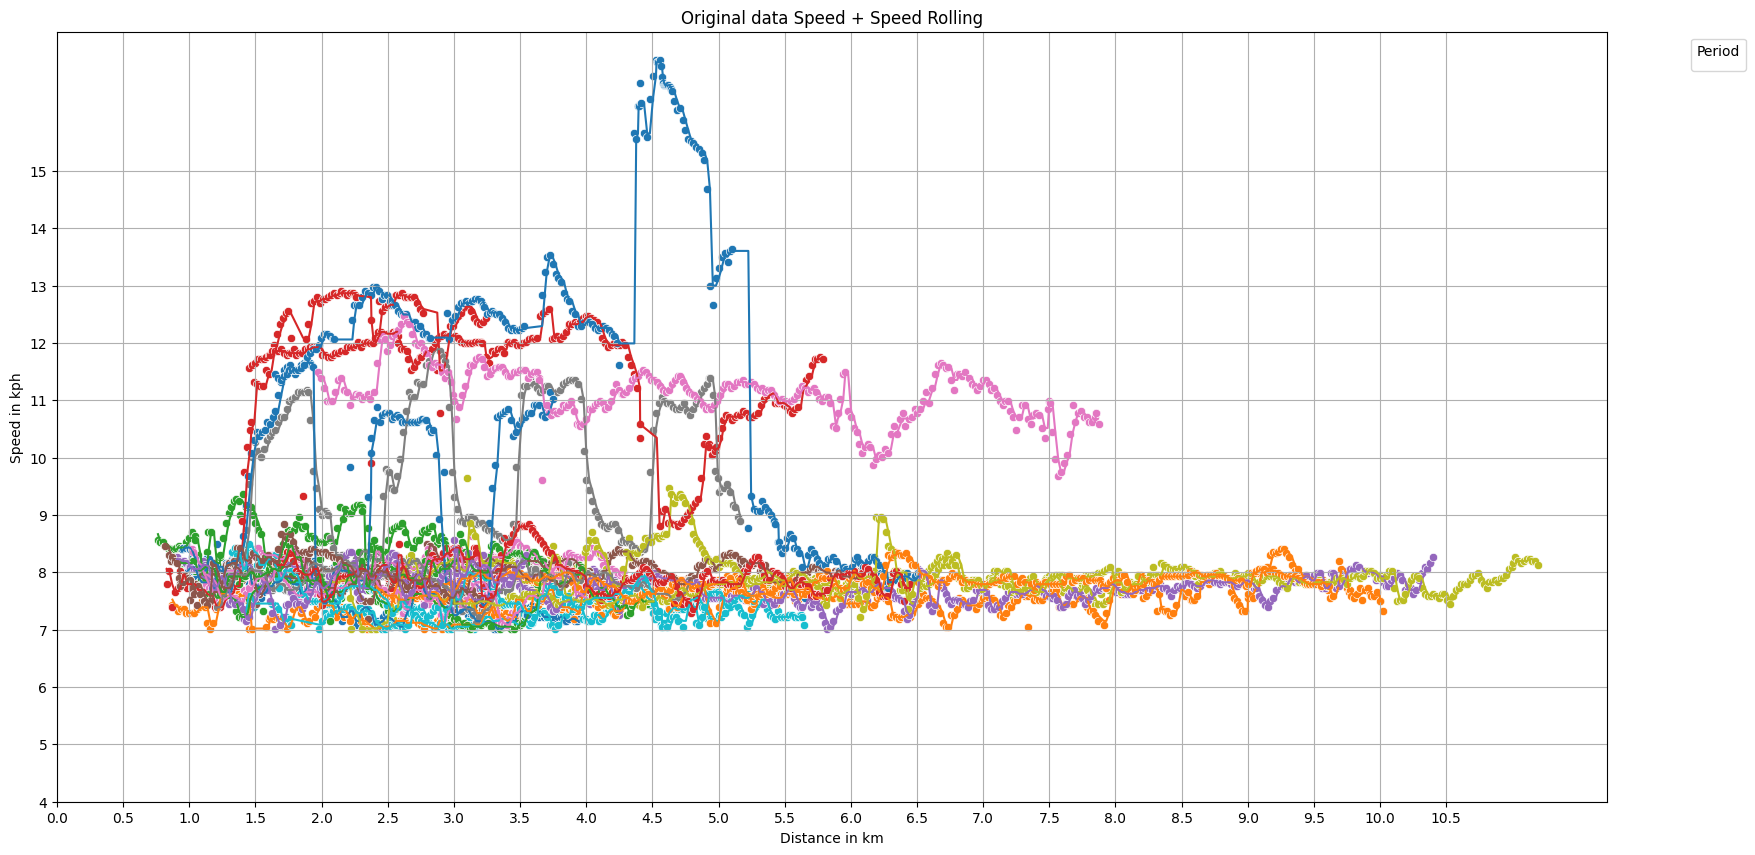

In [8]:
max_distance = grouped_by_activity["Distance"].max().max()

# plotting statitics
plt.figure(figsize=(8,8))

for year in df_plateausStatistics["Year"].unique():
    for month in df_plateausStatistics["Month"].unique():
        data_for_year_month = df_plateausStatistics[(df_plateausStatistics["Year"] == year) & (df_plateausStatistics["Month"] == month)]
        if not data_for_year_month.empty:
            sns.regplot(data=data_for_year_month, x='MeanSpeedR_min_per_km', y='MaxHeartRateR', scatter_kws={'alpha': 0.5}, label=f'{year}-{month}')

plt.title('Heart Rate vs. Pace')
plt.xlabel('Minutes per Kilometer')
plt.ylabel('Beats per Minute')
plt.grid(True)
plt.yticks(np.arange(120, 200, step=5))
plt.ylim(120, 200)
plt.xticks(np.arange(8.5, 3, step=-0.5))  # Reversed the x-axis

plt.gca().invert_xaxis()  # Flip the x-axis

# Move the legend outside to the top-right corner
plt.legend(title='Year-Month', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

# plotting statitics LIT
plt.figure(figsize=(8,8))

df_LIT = df_plateausStatistics[df_plateausStatistics["MaxHeartRateR"] <= 160]

for year in df_LIT["Year"].unique():
    for month in df_LIT["Month"].unique():
        data_for_year_month = df_LIT[(df_LIT["Year"] == year) & (df_LIT["Month"] == month)]
        if not data_for_year_month.empty:
            sns.regplot(data=data_for_year_month, x='MeanSpeedR_min_per_km', y='MaxHeartRateR', scatter_kws={'alpha': 0.5}, label=f'{year}-{month}')

plt.title('Heart Rate vs. Pace')
plt.xlabel('Minutes per Kilometer')
plt.ylabel('Beats per Minute')
plt.grid(True)
#plt.yticks(np.arange(120, 200, step=5))
#plt.ylim(120, 160)
#plt.xticks(np.arange(8.5, 3, step=-0.5))  # Reversed the x-axis

plt.gca().invert_xaxis()  # Flip the x-axis

# Move the legend outside to the top-right corner
plt.legend(title='Year-Month', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

# Plotting HR Plateau
plt.figure(figsize=(20,10))

for activityId in df_plateaus["ActivityId"].unique():
    sns.scatterplot(data=df_plateaus[df_plateaus["ActivityId"] == activityId], x='Distance', y='HeartRateR', marker="s")
    sns.scatterplot(data=df_plateausStatistics, x="MeanDistance", y="MaxHeartRateR", s=200, color='red')

plt.title('Plateau HR Rolling')
plt.xlabel('Distance in km')
plt.ylabel('Heart Rate in bpm')
plt.grid(True)
plt.yticks(np.arange(100, 200, step=5))
plt.xticks(np.arange(0, max_distance, step=.5))
plt.margins(x=0)

plt.show()

# Plotting Speed Plateau
plt.figure(figsize=(20,10))

for activityId in df_plateaus["ActivityId"].unique():
    sns.scatterplot(data=df_plateaus[df_plateaus["ActivityId"] == activityId], x='Distance', y='SpeedR', marker="^")
    sns.scatterplot(data=df_plateausStatistics, x="MeanDistance", y="MeanSpeedR", s=200, color='red')

plt.title('Plateau Speed Rolling')
plt.xlabel('Distance in km')
plt.ylabel('Speed in kph')
plt.grid(True)
plt.yticks(np.arange(4, 16, step=1))
plt.xticks(np.arange(0, max_distance, step=.5))
plt.margins(x=0)

plt.show()

# Plotting hrt
plt.figure(figsize=(20,10))

for activityId in all_data["ActivityId"].unique():
    sns.scatterplot(data=all_data[all_data["ActivityId"] == activityId], x='Distance', y='HeartRate', marker="v")
    sns.lineplot(data=all_data[all_data["ActivityId"] == activityId], x='Distance', y='HeartRateR')

plt.title('Original data HR + HR Rolling')
plt.xlabel('Distance in km')
plt.ylabel('Heart Rate in bpm')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.yticks(np.arange(100, 200, step=5))
plt.xticks(np.arange(0, max_distance, step=.5))

plt.show()

# Plotting speed
plt.figure(figsize=(20,10))

for activityId in all_data["ActivityId"].unique():
    sns.scatterplot(data=all_data[all_data["ActivityId"] == activityId], x='Distance', y='Speed', marker="o")
    sns.lineplot(data=all_data[all_data["ActivityId"] == activityId], x='Distance', y='SpeedR')

plt.title('Original data Speed + Speed Rolling')
plt.xlabel('Distance in km')
plt.ylabel('Speed in kph')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.yticks(np.arange(4, 16, step=1))
plt.xticks(np.arange(0, max_distance, step=.5))


plt.show()